# KSI monitoring: úlohy

V tomto souboru se nachází hlavní tabulka statistik týkajících se úloh.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [17]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
from collections import OrderedDict, namedtuple
from sqlalchemy import func, distinct, text, and_
import pandas as pd
from IPython.display import display, HTML, Markdown
import seaborn as sns

import util
from util.year import year as current_year
from db import session
import model
from datetime import datetime

pd.options.display.float_format = '{:.2f}'.format
plt.rcParams['figure.figsize'] = [10, 8]
print(datetime.now())

2019-05-12 13:05:45.968467


In [3]:
evaluations = session.query(
    model.Task,
    func.count(distinct(model.User.id)).label('evals_count'),
).\
    join(model.Task.r_wave).filter(model.Wave.year == current_year.id).\
    join(model.Task.modules).\
    join(model.Module.evaluations).\
    join(model.Evaluation.r_user).\
    filter(model.User.role == 'participant')

evaluations_per_task = evaluations.\
    group_by(model.Task).order_by(model.Wave.id, model.Task.id)

evaluations_per_task_d = {
    task: evals_count
    for (task, evals_count) in evaluations_per_task.all()
}

In [4]:
successful_evaluations = evaluations_per_task.\
    filter(model.Evaluation.ok == True)

successful_evaluations_d = {
    task: evals_count
    for (task, evals_count) in successful_evaluations.all()
}

In [5]:
per_module = session.query(
    model.Evaluation.user.label('user_id'),
    func.count(model.Evaluation.id).label('eval_count'),
).\
    join(model.Evaluation.r_module).join(model.Module.r_task).\
    join(model.Task.r_wave).\
    filter(model.Wave.year == current_year.id).\
    group_by(model.Evaluation.user,
             model.Evaluation.module).subquery()

EVAL_LIMITS = [10, 30, 50]
problematic_tasks = {
    limit: {
        task: evals_count
        for (task, evals_count) in (
            evaluations.
            filter(model.Evaluation.ok == False).
            join(per_module, per_module.c.user_id == model.User.id).\
            group_by(model.Task).\
            filter(per_module.c.eval_count > limit).all()
        )
    }
    for limit in EVAL_LIMITS
}

In [6]:
all_waves = session.query(model.Wave).\
    filter(model.Wave.year == current_year.id).\
    order_by(model.Wave.index).all()

large_tasks = util.task.large_tasks().all()

In [7]:
def show_wave_stats(wave):
    tasks = [
        (
            task,
            evaluations_per_task_d[task],
            successful_evaluations_d[task],
            successful_evaluations_d[task] / evaluations_per_task_d[task],
            evaluations_per_task_d[task]-successful_evaluations_d[task],
            problematic_tasks[10][task] if task in problematic_tasks[10] else 0,
            problematic_tasks[30][task] if task in problematic_tasks[30] else 0,
            problematic_tasks[50][task] if task in problematic_tasks[50] else 0,
        )
        for task in evaluations_per_task_d
        if task.wave == wave.id
    ]
    tasks.sort(key=lambda x: (x[0] in large_tasks, x[0].id))

    df = pd.DataFrame(tasks, columns=[
        'Task',
        'All Evaluations',
        'Successful Evaluations',
        'Successful/All ratio',
        'N.O. Users failing on task now',
        'N.O. Users with more than 10 unsucc. evaluations',
        'N.O. Users with more than 30 unsucc. evaluations',
        'N.O. Users with more than 50 unsucc. evaluations',
    ]).set_index('Task')
    
    s = df.style
    
    s.background_gradient(subset=[
        'N.O. Users failing on task now',
        'N.O. Users with more than 10 unsucc. evaluations',
        'N.O. Users with more than 30 unsucc. evaluations',
        'N.O. Users with more than 50 unsucc. evaluations',
    ], cmap=sns.light_palette("red", as_cmap=True))
    
    s.background_gradient(
        subset=['Successful/All ratio'],
        cmap=sns.light_palette("green", as_cmap=True)
    )
    
    s.bar(subset=['All Evaluations'], color='#5fd65f')
    
    s.format({'Successful/All ratio': '{:,.1%}'.format})
    
    display(Markdown('# {name}'.format(name=wave.caption)))
    display(s)


for wave in all_waves:
    show_wave_stats(wave)

# Nultá vlna

,All Evaluations,Successful Evaluations,Successful/All ratio,N.O. Users failing on task now,N.O. Users with more than 10 unsucc. evaluations,N.O. Users with more than 30 unsucc. evaluations,N.O. Users with more than 50 unsucc. evaluations
Task,,,,,,,
Vítej v KSI,680,680,100.0%,0,99,17,3
Vaření proměnných,508,497,97.8%,11,189,29,7
Seznámení s pythonem,438,413,94.3%,25,132,24,6
Složitost,420,411,97.9%,9,120,20,5
Korektnost,397,369,92.9%,28,134,25,5
Úvod do seznamů,350,340,97.1%,10,199,41,14
Funkce,285,267,93.7%,18,89,19,5
Start pro zkušené,428,427,99.8%,1,11,0,0
Asymptotická složitost,288,224,77.8%,64,170,39,13


# Hrubá síla

,All Evaluations,Successful Evaluations,Successful/All ratio,N.O. Users failing on task now,N.O. Users with more than 10 unsucc. evaluations,N.O. Users with more than 30 unsucc. evaluations,N.O. Users with more than 50 unsucc. evaluations
Task,,,,,,,
Rekurze,240,240,100.0%,0,82,26,9
Brute-force,240,239,99.6%,1,38,6,1
Permutace,214,208,97.2%,6,78,20,7
Variace s opakováním,230,229,99.6%,1,137,38,11
Variace bez opakování,196,193,98.5%,3,53,12,5
Generování podmnožin,179,174,97.2%,5,103,28,10
Backtracking,145,142,97.9%,3,30,10,3
Problém osmi dam,100,96,96.0%,4,26,11,2
Sebe-referenční test,167,156,93.4%,11,91,25,8


# Rozděl a panuj

,All Evaluations,Successful Evaluations,Successful/All ratio,N.O. Users failing on task now,N.O. Users with more than 10 unsucc. evaluations,N.O. Users with more than 30 unsucc. evaluations,N.O. Users with more than 50 unsucc. evaluations
Task,,,,,,,
Zmenši a panuj,151,150,99.3%,1,3,2,0
Transformuj a panuj,115,106,92.2%,9,54,18,6
Rozděl a panuj,122,121,99.2%,1,93,35,12
Binární vyhledávání,109,108,99.1%,1,62,23,9
QuickSort,107,107,100.0%,0,62,26,9
Rekurzivní volání,103,101,98.1%,2,90,37,12
Rozděluj a slučuj,60,60,100.0%,0,0,0,0
Binárne vyhľadávanie 2.0,76,76,100.0%,0,0,0,0
Karlík jede na soustředění,72,72,100.0%,0,0,0,0


# Dynamické programování

,All Evaluations,Successful Evaluations,Successful/All ratio,N.O. Users failing on task now,N.O. Users with more than 10 unsucc. evaluations,N.O. Users with more than 30 unsucc. evaluations,N.O. Users with more than 50 unsucc. evaluations
Task,,,,,,,
Úvod do dynamického programování,101,97,96.0%,4,43,19,6
Překrývající se problémy,86,66,76.7%,20,77,37,12
Bottom-up,68,68,100.0%,0,21,13,5
Rekurentné vzťahy,66,66,100.0%,0,35,18,6
Rekonstrukce řešení,56,53,94.6%,3,27,15,6
Nejdelší rostoucí podposloupnost,52,51,98.1%,1,49,29,9
Batoh,52,52,100.0%,0,42,23,7
Mince,49,46,93.9%,3,26,15,5
LosKarlosovské součty,38,36,94.7%,2,17,9,3


# NP-těžká vlna

,All Evaluations,Successful Evaluations,Successful/All ratio,N.O. Users failing on task now,N.O. Users with more than 10 unsucc. evaluations,N.O. Users with more than 30 unsucc. evaluations,N.O. Users with more than 50 unsucc. evaluations
Task,,,,,,,
Opakování složitosti,73,73,100.0%,0,54,29,11
Složitostní třídy,60,60,100.0%,0,45,24,10
NP aneb ověřování řešení,52,50,96.2%,2,35,21,7
Redukce,68,48,70.6%,20,64,32,9
Trénink redukcí,45,45,100.0%,0,7,4,2
O NP-úplných problémoch,40,37,92.5%,3,28,19,5
NP hra a řešení složitých problémů,36,36,100.0%,0,19,13,4
Strategie pro NP hru,23,19,82.6%,4,19,11,3
Tvorba karty,29,29,100.0%,0,0,0,0


In [13]:
per_module = session.query(
    model.Wave,
    model.Task,
    model.Evaluation.user.label('user_id'),
    model.Evaluation.module.label('module_id'),
    func.max(model.Evaluation.points).label('points'),
    model.Module.max_points.label('max_points'),
).\
    join(model.Evaluation.r_module).\
    filter(model.Module.type == model.ModuleType.GENERAL).\
    join(model.Module.r_task).join(model.Task.r_wave).\
    filter(model.Wave.year == current_year.id).\
    group_by(model.Task, model.Evaluation.user, model.Evaluation.id).\
    order_by(model.Wave.id)

norm_points = [
    pm.points / pm.max_points
    for pm in per_module
]

df = pd.DataFrame(per_module.all())
df['norm_points'] = norm_points
grouped = df.groupby('Task')

per_task = pd.DataFrame(OrderedDict((
    ('Wave', grouped.Wave.first()),
    ('Solved count', grouped.user_id.count()),
    ('Max Points', grouped.max_points.first()),
    ('Median Points', grouped.points.median()),
    ('Average Points', grouped.points.mean()),
    ('Average Normalized Points', grouped.norm_points.mean()),
    ('Median Normalized Points', grouped.norm_points.median()),
)))
s = per_task.style
s.format({'Average Points': '{:.2f}'.format})
s.format({'Average Normalized Points': '{:,.1%}'.format})
s.format({'Median Normalized Points': '{:,.1%}'.format})

s.background_gradient(subset=[
    'Solved count',
    'Average Normalized Points',
    'Median Normalized Points',
], cmap=sns.light_palette("green", as_cmap=True))

s.background_gradient(subset=[
    'Median Points',
    'Average Points',
], cmap=sns.light_palette("blue", as_cmap=True))

display(s)

,Wave,Solved count,Max Points,Median Points,Average Points,Average Normalized Points,Median Normalized Points
Task,,,,,,,
Jigsaw Sudoku,Hrubá síla,54,10,8,7.76,77.6%,80.0%
Einsteinova hádanka,Hrubá síla,42,10,5,6.04,60.4%,50.0%
Tučňáčí párty,Hrubá síla,85,10,8,7.56,75.6%,80.0%
Rozděluj a slučuj,Rozděl a panuj,60,10,5,4.88,48.8%,50.0%
Binárne vyhľadávanie 2.0,Rozděl a panuj,76,10,9.25,8.44,84.4%,92.5%
Karlík jede na soustředění,Rozděl a panuj,72,10,7.75,7.46,74.6%,77.5%
Karlík v Karlově,Rozděl a panuj,19,5,3,4.16,83.2%,60.0%
LosKarlosovské součty,Dynamické programování,33,7,6.5,4.47,63.8%,92.9%
Trpasličí důl,Dynamické programování,32,10,10,8.97,89.7%,100.0%


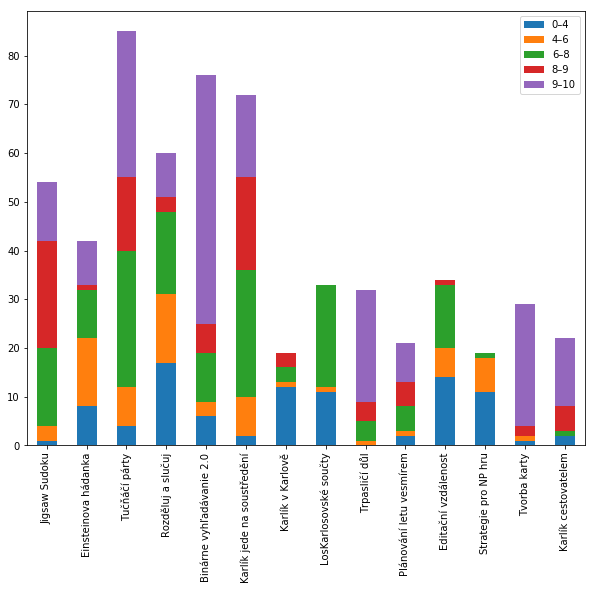

In [22]:
gained_points = pd.DataFrame(OrderedDict((
    ('0–4', df[(df['points'] >= 0) & (df['points'] < 4)].groupby('Task').points.count()),
    ('4–6', df[(df['points'] >= 4) & (df['points'] < 6)].groupby('Task').points.count()),
    ('6–8', df[(df['points'] >= 6) & (df['points'] < 8)].groupby('Task').points.count()),
    ('8–9', df[(df['points'] >= 8) & (df['points'] < 9)].groupby('Task').points.count()),
    ('9–10', df[df['points'] >= 9].groupby('Task').points.count()),
)))
gained_points.plot.bar(stacked=True)